In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cclib.parser import QChem
import itertools

from scipy import constants
eV = constants.value("Hartree energy in eV")

In [11]:
def triangle_to_mat(y):
    mat = np.empty((3, 3))
    mat[0, 0] = y[0]
    mat[0, 1] = mat[1, 0] = y[1]
    mat[0, 2] = mat[2, 0] = y[2]
    mat[1, 1] = y[3]
    mat[1, 2] = mat[2, 1] = y[4]
    mat[2, 2] = y[5]
    return mat

def read_pol(outfile):
    with open(outfile, "r") as tmp:
        lines = tmp.readlines()

    lines = [l.strip() for l in lines]

    pols = []

    for i, l in enumerate(lines):
        if "Polarizability Tensor" in l:
            pol_str = "\n".join(lines[i+2:i+5])
            pol = np.fromstring(pol_str, sep=" ").reshape(3, 3)
            pols.append(pol)

    # xx, xy, xz, yy, yz, zz
    components = list(itertools.combinations_with_replacement([0, 1, 2], r=2))
    response = np.zeros((len(pols), len(components)))

    for i, p in enumerate(pols):
        response[i] = [p[c] for c in components]
        atol = np.max(np.abs(p - p.T))
#         print(atol)
#         assert atol < 1e-4
        np.testing.assert_allclose(triangle_to_mat(response[i]), p, atol=atol)

    comps = ['x', 'y', 'z']
    comps_str = ["a_" + comps[c[0]] + comps[c[1]] for c in components]
    df = pd.DataFrame(data=response, columns=comps_str)
    df['a_iso'] = 1.0 / 3.0 * (df["a_xx"] + df["a_yy"] + df["a_zz"])
    return df


def compute_delta_alpha(df):
    return 0.5 * (df["a_yy"] + df["a_xx"]) - df["a_zz"]


def drop_irreps(df, irreps_wanted):
    irreps_in_df = df.irrep.unique()
    for irr in irreps_in_df:
        if irr not in irreps_wanted:
            indexNames = df[df['irrep'] == irr].index
            df.drop(indexNames, inplace=True)

## Definitions of all jobs/molecules

In [12]:
jobs = {
     "s-tetrazine": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "stetrazine",
         "qchem_name": "stetrazine_gs",
         "irreps_wanted": ['X'],
         "state_limit": 1,
     },
     "s-tetrazine-exc": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "stetrazine",
         "qchem_name": "stetrazine_b13u",
         "irreps_wanted": ['B1u'],
         "state_limit": 1,
     },
     "pyrimidine": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "pyrimidine",
         "qchem_name": "pyrimidine",
         "irreps_wanted": ['X', 'B2'],
         "state_limit": 2,
     },
     "uracil": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "uracil",
         "qchem_name": "uracil",
         "irreps_wanted": ['X', 'A"', "A'"],
         "state_limit": 2,
     },
     "pna": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "pna",
         "qchem_name": "pna",
         "irreps_wanted": ["X", "A1"],
         "state_limit": 1,
     },
     "formaldehyde": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "formaldehyde",
         "qchem_name": "formaldehyde",
         "irreps_wanted": ["X", "B1"],
         "state_limit": 1,
     },
     "naphthalene": {
         "adc_methods": ["adc2", "adc2x", "adc3"],
         "qchem_folder": "naphthalene",
         "qchem_name": "naphthalene",
         "irreps_wanted": ["X", "B3u"],
         "state_limit": 1,
     }
}

nice_labels = {
    "a_xx": r"$\alpha_{xx}$",
    "a_yy": r"$\alpha_{yy}$",
    "a_zz": r"$\alpha_{zz}$",
    "a_iso": r"$\alpha_\text{iso}$",
    "etenergies": r"$E_\text{exc}$",
    "adc2": "ADC(2)",
    "adc2x": "ADC(2)-x",
    "adc3": "ADC(3)",
    "ccsd_der": "CCSD Der.",
    "ccsd_ev": "CCSD E.V.",
}

## Generate summary tables for each molecule

In [13]:
dfcs = []
for j in jobs.keys():
    print(j)
    job = jobs[j]
    system_name = j
    qchem_name = job["qchem_name"]
    qchem_folder = job["qchem_folder"]
    irreps_wanted = job["irreps_wanted"]
    state_limit = job["state_limit"]
    all_dfs = []
    
    d_eom_ev = QChem(f"ccsd/{qchem_folder}/{qchem_name}_eompol4.out").parse()
    alphas_ev = read_pol(f"ccsd/{qchem_folder}/{qchem_name}_eompol4.out")
    alphas_ev["system"] = system_name
    alphas_ev["method"] = "ccsd_ev"
    alphas_ev["etenergies"] = 0.0
    alphas_ev["irrep"] = "X"
    for i, ee in enumerate(d_eom_ev.etenergies, 1):
        alphas_ev.etenergies.values[i] = ee
        alphas_ev.irrep.values[i] = d_eom_ev.etirreps[i-1]
    drop_irreps(alphas_ev, irreps_wanted)
    alphas_ev.sort_values(by=["etenergies"], inplace=True)
    alphas_ev["state"] = range(len(alphas_ev.etenergies + 1))
        
    d_eom_der = QChem(f"ccsd/{qchem_folder}/{qchem_name}_eompol2.out").parse()
    alphas_der = read_pol(f"ccsd/{qchem_folder}/{qchem_name}_eompol2.out")
    alphas_der["system"] = system_name
    alphas_der["method"] = "ccsd_der"
    alphas_der["etenergies"] = 0.0
    alphas_der["irrep"] = "X"
    for i, ee in enumerate(d_eom_der.etenergies, 1):
        alphas_der.etenergies.values[i] = ee
        alphas_der.irrep.values[i] = d_eom_der.etirreps[i-1]
    drop_irreps(alphas_der, irreps_wanted)
    alphas_der.sort_values("etenergies", inplace=True)
    alphas_der["state"] = range(len(alphas_der.etenergies + 1))
    
    alphas_der["delta_alpha"] = compute_delta_alpha(alphas_der)
    alphas_ev["delta_alpha"] = compute_delta_alpha(alphas_ev)
        
    # loop over ADC methods
    dfs_adc = []
    for method in job["adc_methods"]:
        df_adcc = pd.read_pickle(f"results/{system_name}-{method}.pkl")
        df_adcc["system"] = system_name
        df_adcc["method"] = method
        df_adcc["etenergies"] = df_adcc["ee"] * eV
        df_adcc.drop(columns=["ee"], inplace=True)
                
        d_adc = QChem(f"ccsd/{qchem_folder}/{qchem_name}_{method}.out").parse()
        
        # determine the irrep of the adcc excited state from Q-Chem results
        df_adcc["irrep"] = "NN"
        for ia, ee in enumerate(df_adcc.etenergies.values):
            if np.isnan(ee):
                df_adcc.irrep.values[ia] = "X"
                df_adcc.etenergies.values[ia] = 0.0
                continue
            for ii, ee_qc in enumerate(d_adc.etenergies):
                if np.abs(ee-ee_qc) < 1e-4:
                    irrep = d_adc.etirreps[ii]
                    df_adcc.irrep.values[ia] = irrep
        # delete cells with unassignable irrep
        drop_irreps(df_adcc, irreps_wanted)
        df_adcc["state"] = range(len(df_adcc.etenergies + 1))
        
        df_adcc["delta_alpha"] = compute_delta_alpha(df_adcc)
        
        dfs_adc.append(df_adcc)
    
    all_dfs.extend(dfs_adc)
    all_dfs.extend([alphas_ev, alphas_der])
    df = pd.concat(all_dfs, sort=False, ignore_index=True)

    dfc = df.drop(columns=["a_xy", "a_xz", "a_yz"])
    dfc = dfc.query(f'state <= {state_limit}')
    dfcs.append(dfc)

    irrep_string = ", ".join([f'\"{i}\"' for i in irreps_wanted])
    df = df.query(f'state <= {state_limit}')
    
    order = irreps_wanted
    values = [
        "a_xx", "a_yy", "a_zz",
        "a_iso",
        "etenergies"
    ]
    dfp = pd.pivot_table(df, index=["method"], values=values, columns=["irrep"])

    dfp = dfp.swaplevel(0, 1, axis=1).sort_index(axis=1)
    cols = list(itertools.product(order, values))
    dfp = dfp.reindex(cols, axis=1)
    dfp = dfp.round(2)
    
    new_labels_level1 = [nice_labels.get(label, label) for label in dfp.columns.levels[1].values]
    dfp.columns.set_levels(new_labels_level1, level=1, inplace=True)
    
    new_labels_index = [nice_labels.get(label, label) for label in dfp.index.values]
    dfp.index = new_labels_index
        
    display(dfp)

s-tetrazine


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)            66.08         61.26         33.50               53.61   
ADC(2)-x          69.38         64.96         35.72               56.69   
ADC(3)            64.10         59.57         33.41               52.36   
CCSD Der.         60.73         56.02         32.73               49.83   
CCSD E.V.         62.82         58.01         33.48               51.44   

irrep                     
          $E_\text{exc}$  
ADC(2)               0.0  
ADC(2)-x             0.0  
ADC(3)               0.0  
CCSD Der.            0.0  
CCSD E.V.            0.0

s-tetrazine-exc


irrep               B1u                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)            39.06         78.55         15.71               44.44   
ADC(2)-x          50.64         80.08         21.60               50.77   
ADC(3)            57.28         74.94         25.90               52.70   
CCSD Der.         66.03         80.09         31.93               59.35   
CCSD E.V.         49.28         71.75         23.05               48.03   

irrep                     
          $E_\text{exc}$  
ADC(2)              2.20  
ADC(2)-x            1.31  
ADC(3)              2.18  
CCSD Der.           2.39  
CCSD E.V.           2.39

pyrimidine


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)            73.48         38.69         76.22               62.80   
ADC(2)-x          77.21         39.99         79.97               65.72   
ADC(3)            71.24         38.27         73.61               61.04   
CCSD Der.         67.79         37.50         70.18               58.49   
CCSD E.V.         70.05         38.25         72.52               60.27   

irrep                               B2                              \
          $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$   
ADC(2)               0.0        118.89         26.65         38.79   
ADC(2)-x             0.0        114.28         31.22         51.10   
ADC(3)               0.0        104.45         33.64         57.48   
CCSD Der.            0.0        111.76         42.13         71.38   
CCSD E.V.            0.0        102.93         33.16         51.14   

irrep                                         
          $\alpha_\text{iso}$ $E_\text{exc}$  
ADC(2)                  61.45           4.32  
ADC(2)-x                65.53           3.44  
ADC(3)                  65.19           4.50  
CCSD Der.               75.09           4.59  
CCSD E.V.               62.41           4.59

uracil


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)           105.23         80.00         43.37               76.20   
ADC(2)-x         110.75         83.17         44.48               79.47   
ADC(3)            98.47         76.27         42.30               72.35   
CCSD Der.         95.82         74.62         41.59               70.67   
CCSD E.V.         98.75         76.41         42.42               72.53   

irrep                               A"                              \
          $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$   
ADC(2)               0.0         86.44         67.30         27.08   
ADC(2)-x             0.0         85.17         73.16         33.17   
ADC(3)               0.0         74.72         70.74         36.03   
CCSD Der.            0.0         98.08         88.29         45.19   
CCSD E.V.            0.0         71.49         69.43         34.55   

irrep                                                   A'                \
          $\alpha_\text{iso}$ $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$   
ADC(2)                  60.28           4.73        138.88         81.77   
ADC(2)-x                63.83           3.97        147.08         87.72   
ADC(3)                  60.50           5.36        105.12         86.93   
CCSD Der.               77.19           5.22        133.94        102.78   
CCSD E.V.               58.49           5.22        112.82         85.86   

irrep                                                       
          $\alpha_{zz}$ $\alpha_\text{iso}$ $E_\text{exc}$  
ADC(2)            35.46               85.37           5.32  
ADC(2)-x          38.37               91.06           4.61  
ADC(3)            42.27               78.11           5.38  
CCSD Der.         51.69               96.14           5.58  
CCSD E.V.         42.97               80.55           5.58

pna


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)           118.84         58.94        168.68              115.49   
ADC(2)-x         125.29         60.62        183.45              123.12   
ADC(3)           112.76         58.02        162.94              111.24   
CCSD Der.        106.38         56.95        152.90              105.41   
CCSD E.V.        110.76         58.20        157.68              108.88   

irrep                               A1                              \
          $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$   
ADC(2)               0.0         68.26         49.52        196.97   
ADC(2)-x             0.0         82.44         50.60        176.49   
ADC(3)               0.0         86.53         59.25        204.37   
CCSD Der.            0.0        109.60         83.60        239.08   
CCSD E.V.            0.0         74.95         69.30        200.89   

irrep                                         
          $\alpha_\text{iso}$ $E_\text{exc}$  
ADC(2)                 104.92           4.30  
ADC(2)-x               103.18           3.56  
ADC(3)                 116.72           4.23  
CCSD Der.              144.09           4.62  
CCSD E.V.              115.05           4.62

formaldehyde


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)            17.94         12.88         24.90               18.57   
ADC(2)-x          18.40         13.20         25.65               19.09   
ADC(3)            17.31         12.68         23.47               17.82   
CCSD Der.         17.23         12.50         22.58               17.44   
CCSD E.V.         17.39         12.66         22.98               17.67   

irrep                               B1                              \
          $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$   
ADC(2)               0.0        712.91        243.79        310.03   
ADC(2)-x             0.0        641.26        250.44        314.84   
ADC(3)               0.0        678.81        281.39        432.19   
CCSD Der.            0.0        680.32        272.78        384.16   
CCSD E.V.            0.0        688.15        272.27        388.23   

irrep                                         
          $\alpha_\text{iso}$ $E_\text{exc}$  
ADC(2)                 422.25           6.27  
ADC(2)-x               402.18           5.98  
ADC(3)                 464.13           7.57  
CCSD Der.              445.75           7.05  
CCSD E.V.              449.55           7.05

naphthalene


irrep                 X                                                  \
          $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$ $\alpha_\text{iso}$   
ADC(2)           182.04        133.68         69.29              128.34   
ADC(2)-x         194.22        140.69         71.34              135.42   
ADC(3)           177.81        129.95         68.62              125.46   
CCSD Der.        166.78        123.14         66.67              118.86   
CCSD E.V.        173.89        128.11         68.22              123.41   

irrep                              B3u                              \
          $E_\text{exc}$ $\alpha_{xx}$ $\alpha_{yy}$ $\alpha_{zz}$   
ADC(2)               0.0        178.48         73.79         44.13   
ADC(2)-x             0.0        164.97         88.51         50.91   
ADC(3)               0.0        170.71         98.76         56.14   
CCSD Der.            0.0        195.12        121.47         70.32   
CCSD E.V.            0.0        164.30         88.58         54.89   

irrep                                         
          $\alpha_\text{iso}$ $E_\text{exc}$  
ADC(2)                  98.80           4.45  
ADC(2)-x               101.47           3.46  
ADC(3)                 108.53           4.16  
CCSD Der.              128.97           4.41  
CCSD E.V.              102.59           4.41

## Generate table with $\delta_\text{Der}$

In [14]:
sns.set_context("paper")

dfcs_df = pd.concat(dfcs, sort=False, ignore_index=True)
dfm_full = dfcs_df.melt(id_vars=['system', 'method', 'irrep', 'state'], var_name='property')

dfm_full['state_kind'] = dfm_full.apply(lambda row : "ground_state" if row['irrep'] == "X" else "excited_state", axis=1)

# merge the s-tetrazine results
dfm_full.loc[dfm_full['system'] == "s-tetrazine-exc", 'system'] = 's-tetrazine'

systems = dfm_full.system.unique()
dfs_diff = []

for system in systems:
    dfm = dfm_full.query(f'system == "{system}" and property in ["a_iso"]').copy()
    dfm.sort_values(["method", "state", "property"], inplace=True)

    nrepeats = dfm.method.unique().size

    ref_res = np.tile(dfm.query('method == "ccsd_der"')['value'].values, nrepeats)
    dfm['diff'] = np.abs(dfm['value'].values - ref_res)
    dfm['diff_perc'] = np.abs(dfm['value'].values - ref_res)/ref_res * 100

    dfm.drop(dfm.query('method == "ccsd_der"').index, inplace=True)
    display(system, dfm.groupby(['method', 'state_kind'])['diff'].describe())
    
    dfs_diff.append(dfm)

df_diff_summary = pd.concat(dfs_diff, ignore_index=True)

's-tetrazine'

count       mean  std        min        25%        50%  \
method  state_kind                                                              
adc2    excited_state    1.0  14.908393  NaN  14.908393  14.908393  14.908393   
        ground_state     1.0   3.782156  NaN   3.782156   3.782156   3.782156   
adc2x   excited_state    1.0   8.577088  NaN   8.577088   8.577088   8.577088   
        ground_state     1.0   6.859052  NaN   6.859052   6.859052   6.859052   
adc3    excited_state    1.0   6.644517  NaN   6.644517   6.644517   6.644517   
        ground_state     1.0   2.532045  NaN   2.532045   2.532045   2.532045   
ccsd_ev excited_state    1.0  11.321240  NaN  11.321240  11.321240  11.321240   
        ground_state     1.0   1.608649  NaN   1.608649   1.608649   1.608649   

                             75%        max  
method  state_kind                           
adc2    excited_state  14.908393  14.908393  
        ground_state    3.782156   3.782156  
adc2x   excited_state   8.577088   8.577088  
        ground_state    6.859052   6.859052  
adc3    excited_state   6.644517   6.644517  
        ground_state    2.532045   2.532045  
ccsd_ev excited_state  11.321240  11.321240  
        ground_state    1.608649   1.608649

'pyrimidine'

count       mean  std        min        25%        50%  \
method  state_kind                                                              
adc2    excited_state    1.0  13.645504  NaN  13.645504  13.645504  13.645504   
        ground_state     1.0   4.308216  NaN   4.308216   4.308216   4.308216   
adc2x   excited_state    1.0   9.557275  NaN   9.557275   9.557275   9.557275   
        ground_state     1.0   7.233721  NaN   7.233721   7.233721   7.233721   
adc3    excited_state    1.0   9.903917  NaN   9.903917   9.903917   9.903917   
        ground_state     1.0   2.552216  NaN   2.552216   2.552216   2.552216   
ccsd_ev excited_state    1.0  12.681450  NaN  12.681450  12.681450  12.681450   
        ground_state     1.0   1.784420  NaN   1.784420   1.784420   1.784420   

                             75%        max  
method  state_kind                           
adc2    excited_state  13.645504  13.645504  
        ground_state    4.308216   4.308216  
adc2x   excited_state   9.557275   9.557275  
        ground_state    7.233721   7.233721  
adc3    excited_state   9.903917   9.903917  
        ground_state    2.552216   2.552216  
ccsd_ev excited_state  12.681450  12.681450  
        ground_state    1.784420   1.784420

'uracil'

count       mean       std        min        25%  \
method  state_kind                                                        
adc2    excited_state    2.0  13.839546  4.343324  10.768352  12.303949   
        ground_state     1.0   5.522694       NaN   5.522694   5.522694   
adc2x   excited_state    2.0   9.218170  5.849056   5.082263   7.150217   
        ground_state     1.0   8.792128       NaN   8.792128   8.792128   
adc3    excited_state    2.0  17.360959  0.947795  16.690767  17.025863   
        ground_state     1.0   1.671980       NaN   1.671980   1.671980   
ccsd_ev excited_state    2.0  17.141945  2.196489  15.588793  16.365369   
        ground_state     1.0   1.854225       NaN   1.854225   1.854225   

                             50%        75%        max  
method  state_kind                                      
adc2    excited_state  13.839546  15.375143  16.910740  
        ground_state    5.522694   5.522694   5.522694  
adc2x   excited_state   9.218170  11.286124  13.354077  
        ground_state    8.792128   8.792128   8.792128  
adc3    excited_state  17.360959  17.696056  18.031152  
        ground_state    1.671980   1.671980   1.671980  
ccsd_ev excited_state  17.141945  17.918521  18.695098  
        ground_state    1.854225   1.854225   1.854225

'pna'

count       mean  std        min        25%        50%  \
method  state_kind                                                              
adc2    excited_state    1.0  39.171556  NaN  39.171556  39.171556  39.171556   
        ground_state     1.0  10.077839  NaN  10.077839  10.077839  10.077839   
adc2x   excited_state    1.0  40.912979  NaN  40.912979  40.912979  40.912979   
        ground_state     1.0  17.709939  NaN  17.709939  17.709939  17.709939   
adc3    excited_state    1.0  27.372484  NaN  27.372484  27.372484  27.372484   
        ground_state     1.0   5.829036  NaN   5.829036   5.829036   5.829036   
ccsd_ev excited_state    1.0  29.042883  NaN  29.042883  29.042883  29.042883   
        ground_state     1.0   3.470106  NaN   3.470106   3.470106   3.470106   

                             75%        max  
method  state_kind                           
adc2    excited_state  39.171556  39.171556  
        ground_state   10.077839  10.077839  
adc2x   excited_state  40.912979  40.912979  
        ground_state   17.709939  17.709939  
adc3    excited_state  27.372484  27.372484  
        ground_state    5.829036   5.829036  
ccsd_ev excited_state  29.042883  29.042883  
        ground_state    3.470106   3.470106

'formaldehyde'

count       mean  std        min        25%        50%  \
method  state_kind                                                              
adc2    excited_state    1.0  23.506629  NaN  23.506629  23.506629  23.506629   
        ground_state     1.0   1.137442  NaN   1.137442   1.137442   1.137442   
adc2x   excited_state    1.0  43.573935  NaN  43.573935  43.573935  43.573935   
        ground_state     1.0   1.652945  NaN   1.652945   1.652945   1.652945   
adc3    excited_state    1.0  18.376395  NaN  18.376395  18.376395  18.376395   
        ground_state     1.0   0.383822  NaN   0.383822   0.383822   0.383822   
ccsd_ev excited_state    1.0   3.797406  NaN   3.797406   3.797406   3.797406   
        ground_state     1.0   0.238897  NaN   0.238897   0.238897   0.238897   

                             75%        max  
method  state_kind                           
adc2    excited_state  23.506629  23.506629  
        ground_state    1.137442   1.137442  
adc2x   excited_state  43.573935  43.573935  
        ground_state    1.652945   1.652945  
adc3    excited_state  18.376395  18.376395  
        ground_state    0.383822   0.383822  
ccsd_ev excited_state   3.797406   3.797406  
        ground_state    0.238897   0.238897

'naphthalene'

count       mean  std        min        25%        50%  \
method  state_kind                                                              
adc2    excited_state    1.0  30.169879  NaN  30.169879  30.169879  30.169879   
        ground_state     1.0   9.471656  NaN   9.471656   9.471656   9.471656   
adc2x   excited_state    1.0  27.504856  NaN  27.504856  27.504856  27.504856   
        ground_state     1.0  16.554579  NaN  16.554579  16.554579  16.554579   
adc3    excited_state    1.0  20.434990  NaN  20.434990  20.434990  20.434990   
        ground_state     1.0   6.598653  NaN   6.598653   6.598653   6.598653   
ccsd_ev excited_state    1.0  26.377231  NaN  26.377231  26.377231  26.377231   
        ground_state     1.0   4.545180  NaN   4.545180   4.545180   4.545180   

                             75%        max  
method  state_kind                           
adc2    excited_state  30.169879  30.169879  
        ground_state    9.471656   9.471656  
adc2x   excited_state  27.504856  27.504856  
        ground_state   16.554579  16.554579  
adc3    excited_state  20.434990  20.434990  
        ground_state    6.598653   6.598653  
ccsd_ev excited_state  26.377231  26.377231  
        ground_state    4.545180   4.545180

## Generate table with C6 dispersion coefficients

In [15]:
values = ["c6"]
dfp = pd.pivot_table(dfcs_df, index=["system", "irrep"], values=values, columns=["method"])
display(dfp)

c6                          
method                        adc2        adc2x         adc3
system          irrep                                       
pna             A1     2334.708421          NaN          NaN
                X      4396.756604          NaN          NaN
pyrimidine      X      1510.358705  1555.602192  1468.867995
                B2      889.046026  1044.240795  1160.842013
s-tetrazine     X      1161.050358  1197.540012  1129.030249
s-tetrazine-exc B1u     642.847364   795.372863   910.021774
uracil          X      2237.450379          NaN          NaN
                A"     1099.272240          NaN          NaN
                A'     1355.938320          NaN          NaN

## Generate figure for naphthalene (comparison with experiment)

,system,method,irrep,state,a_xx,a_yy,a_zz,a_iso
0,naphthalene,experiment,X,0,162.0,119.5,70.9,117.466667
1,naphthalene,experiment,B3u,1,186.9,120.1,76.9,127.966667


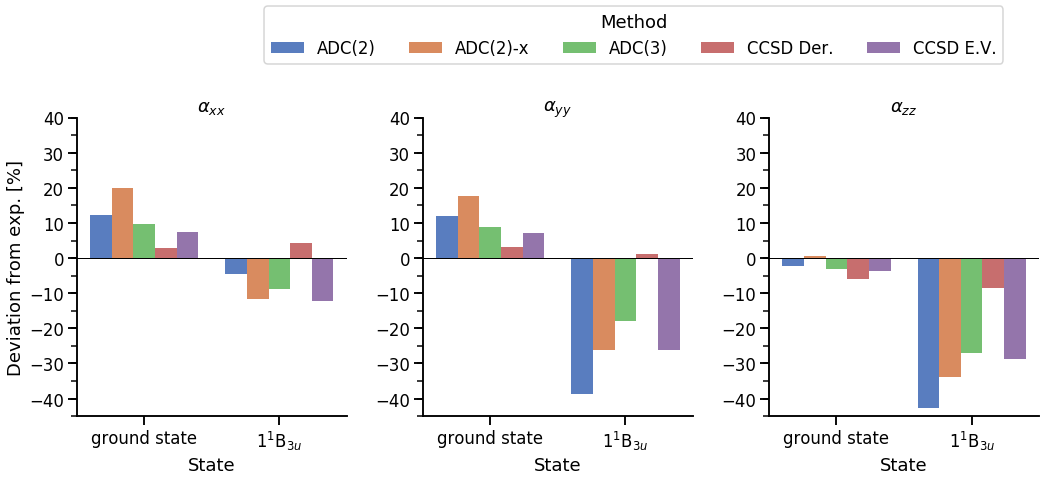

In [16]:
sns.set_context("talk")
dfcs_df = pd.concat(dfcs, sort=False, ignore_index=True)

data_exp = [
    ["naphthalene", "experiment", "X", 0, 162.0, 119.5, 70.9],
    ["naphthalene", "experiment", "B3u", 1, 186.9, 120.1, 76.9]
]

df_experiment = pd.DataFrame(columns=["system", "method", "irrep", "state", "a_xx", "a_yy", "a_zz"], data=data_exp)
df_experiment["a_iso"] = 1./3. * (df_experiment["a_xx"] + df_experiment["a_yy"] + df_experiment["a_zz"])
display(df_experiment)

dfcs_df = pd.concat([dfcs_df, df_experiment], sort=False, ignore_index=True)

dfm_full = dfcs_df.melt(id_vars=['system', 'method', 'irrep', 'state'], var_name='property')

dfm_full['state_kind'] = dfm_full.apply(lambda row : "ground_state" if row['irrep'] == "X" else "excited_state", axis=1)

# # merge the s-tetrazine results
dfm_full.loc[dfm_full['system'] == "s-tetrazine-exc", 'system'] = 's-tetrazine'

dfm = dfm_full.query(f'system == "naphthalene" and property in ["a_xx", "a_yy", "a_zz"]').copy()
dfm.sort_values(["method", "state", "property"], inplace=True)

nrepeats = dfm.method.unique().size
ref_res = np.tile(dfm.query('method == "experiment"')['value'].values, nrepeats)
dfm['diff'] = dfm['value'].values - ref_res
dfm['diff_perc'] = (dfm['value'].values - ref_res)/ref_res * 100

dfm.drop(dfm.query('method == "experiment"').index, inplace=True)

g = sns.catplot(x="irrep", y="diff_perc", col="property", hue="method",
                kind="bar", data=dfm, sharex=False, sharey=False,
                legend=False, palette="muted", legend_out=False)
g.fig.set_size_inches(15, 6)

for ax1 in g.axes:
    for ax, lab in zip(ax1, [r"$\alpha_{xx}$", r"$\alpha_{yy}$", r"$\alpha_{zz}$"]):
        ax.axhline(0, color="black", lw=1.0)
        ax.set_title(lab)
        ax.set_yticks(np.arange(-45, 45, 5), minor=True);
g.set_xlabels("State")
g.set_xticklabels(["ground state", r"$1^1$B$_{3u}$"])
g.set_ylabels("Deviation from exp. [%]")
g.set(ylim=(-45, 40))

new_labels = ['ADC(2)', 'ADC(2)-x', "ADC(3)", "CCSD Der.", "CCSD E.V."]
leg = plt.legend(loc='upper center', title="Method", bbox_to_anchor=(-0.5, 1.4), fancybox=True, ncol=5)
# g._legend.set_title("Method")

for t, l in zip(leg.texts, new_labels): t.set_text(l)

plt.savefig("naphthalene_experiment.png", bbox_inches='tight', bbox_extra_artist=[leg])

## Generate a CSV table with all results

In [17]:
fields = ["system", "method", "irrep", "state", "etenergies", "a_xx", "a_yy", "a_zz", "c6", "f", "tdipmom_x", "tdipmom_y", "tdipmom_z", "dipmom_x", "dipmom_y", "dipmom_z"]
dfcs_df = dfcs_df.reindex(fields, axis=1)
dfcs_df = dfcs_df.round(4)
dfcs_df = dfcs_df.fillna('...')
display(dfcs_df)
dfcs_df.to_csv("adc_excipol_results.csv")

,system,method,irrep,state,etenergies,a_xx,a_yy,a_zz,c6,f,tdipmom_x,tdipmom_y,tdipmom_z,dipmom_x,dipmom_y,dipmom_z
0,s-tetrazine,adc2,X,0,0,66.0774,61.2568,33.4974,1161.05,...,...,...,...,0,0,-0
1,s-tetrazine,adc2x,X,0,0,69.3787,64.9631,35.7206,1197.54,...,...,...,...,-0,0,0
2,s-tetrazine,adc3,X,0,0,64.1000,59.5691,33.4122,1129.03,...,...,...,...,-0,0,-0
3,s-tetrazine,ccsd_ev,X,0,0,62.8234,58.0086,33.4792,...,...,...,...,...,...,...,...
4,s-tetrazine,ccsd_der,X,0,0,60.7296,56.0214,32.7342,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,naphthalene,ccsd_ev,B3u,1,4.4052,164.3049,88.5818,54.8913,...,...,...,...,...,...,...,...
63,naphthalene,ccsd_der,X,0,0,166.7821,123.1357,66.6723,...,...,...,...,...,...,...,...
64,naphthalene,ccsd_der,B3u,1,4.4052,195.1152,121.4741,70.3204,...,...,...,...,...,...,...,...
65,naphthalene,experiment,X,0,...,162.0000,119.5000,70.9000,...,...,...,...,...,...,...,...
